# Link human and mouse whole-brain phenotype

* Perform dual regression using graph embeddings as a mediator.

In [1]:
import pandas as pd
import numpy  as np
from nilearn import image,plotting

In [2]:
import pickle

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [4]:
from scipy import stats

In [5]:
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import matplotlib.image as mpimg

In [8]:
from matplotlib import pyplot as plt

## Define mapping rois of humans and mice

In [9]:
human_select_cortex_region = ['A8m', 'A8dl', 'A9l','A6dl', 'A6m', 'A9m', 'A10m', 'A9/46d', 'IFJ', 'A46', 'A9/46v', 'A8vl', 'A6vl','A10l', 'A44d', 'IFS', 'A45c', 'A45r', 'A44op', 'A44v','A14m', 'A12/47o', 'A11l','A11m', 'A13', 'A12/47l','A32p','A32sg',
                'A24cd','A24rv','A4hf', 'A6cdl', 'A4ul', 'A4t', 'A4tl', 'A6cvl','A1/2/3ll', 'A4ll','A1/2/3ulhf', 'A1/2/3tonIa', 'A2','A1/2/3tru','A7r', 'A7c', 'A5l', 'A7pc', 'A7ip', 'A39c', 'A39rd', 'A40rd', 'A40c', 'A39rv','A40rv', 'A7m', 'A5m', 'dmPOS',
                'A31','A23d','A23c','A23v','cLinG', 'rCunG','cCunG', 'rLinG', 'vmPOS', 'mOccG', 'V5/MT+', 'OPC', 'iOccG', 'msOccG', 'lsOccG', 'G', 'vIa', 'dIa', 'vId/vIg', 'dIg', 'dId','A38m', 'A41/42', 'TE1.0 and TE1.2', 'A22c', 'A38l', 'A22r', 'A21c',
                'A21r', 'A37dl', 'aSTS', 'A20iv', 'A37elv', 'A20r', 'A20il', 'A37vl', 'A20cl','A20cv', 'A20rv', 'A37mv', 'A37lv', 'A35/36r', 'A35/36c', 'lateral PPHC', 'A28/34', 'TH','TI','rpSTS','cpSTS']
mouse_select_cortex_region = ['ACAd', 'ACAv', 'PL','ILA', 'ORBl', 'ORBm', 'ORBvl','MOp','SSp-n', 'SSp-bfd', 'SSp-ll', 'SSp-m',
       'SSp-ul', 'SSp-tr', 'SSp-un','SSs','PTLp','RSPagl','RSPd', 'RSPv','VISpm','VISp','VISal','VISl','VISpl','AId','AIp','AIv','GU','VISC','TEa', 'PERI', 'ECT','AUDd', 'AUDp',
       'AUDpo', 'AUDv']

human_select_subcortex_region = ['mAmyg', 'lAmyg', 'CA1', 'CA4DG', 'CA2CA3', 'subiculum','Claustrum', 'head of caudate', 'body of caudate', 'Putamen',
       'posterovemtral putamen', 'nucleus accumbens','external segment of globus pallidus','internal segment of globus pallidus', 'mPMtha', 'Stha','cTtha', 'Otha',
        'mPFtha','lPFtha','rTtha', 'PPtha']
mouse_select_subcortex_region = ['LA', 'BLA', 'BMA', 'PA','CA1', 'CA2', 'CA3', 'DG', 'SUB', 'ACB', 'CP', 'FS', 'SF', 'SH','sAMY', 'PAL', 'VENT', 'SPF', 'SPA', 'PP', 'GENd', 'LAT', 'ATN',
       'MED', 'MTN', 'ILM', 'GENv', 'EPI', 'RT']

Human_select_region = human_select_cortex_region + human_select_subcortex_region
Mouse_select_region = mouse_select_cortex_region + mouse_select_subcortex_region

## Define mapping function

In [10]:
def dual_mapping_data(pheno_path,Mouse_matrix,Human_matrix,dual_type=None,i=0):

    
    if not dual_type:
        
        return
    
    with open(pheno_path,'rb') as f:
        pheno_data=pickle.load(f)
    
    Mouse_matrix=Mouse_matrix.values
    Human_matrix=Human_matrix.values
    
    zero_data=np.zeros((pheno_data.shape[0],Human_matrix.shape[0]))
    
    for i in range(pheno_data.shape[0]):
        
        min_max_scaler=MinMaxScaler()
        model = LinearRegression()
        pheno_y=pheno_data[i]
        
        pheno_y_normalized = pheno_y.reshape(-1, 1)
        pheno_y_normalized = min_max_scaler.fit_transform(pheno_y_normalized)
        pheno_y_normalized = pheno_y_normalized.ravel()

        model.fit(Mouse_matrix, pheno_y_normalized)

        y_human = model.predict(Human_matrix)
        
        zero_data[i]=y_human

    return zero_data

## Load Graph embeddings

In [11]:
with open('../../Graphembeddings/Human_Mouse_p0.01_q0.1_graph_embeddings.pkl','rb') as f:
    Human_Mouse_embedding=pickle.load(f)

## Gradient

In [12]:
with open('./gradient_file/mouse_gradient_dict_nozscore.pkl','rb') as f:
    mouse_gradient_dict = pickle.load(f)

In [13]:
for key in mouse_gradient_dict.keys():
    mouse_gradient_dict[key] = mouse_gradient_dict[key].T[mouse_select_cortex_region].T

### translate mouse gradient to human

In [14]:
graph_map_dict_gradient={}

for key in mouse_gradient_dict.keys():
    
    mouse_array = np.asarray([mouse_gradient_dict[key].iloc[:,0].values])
    expanded_array = np.pad(mouse_array, ((0, 0), (0, 66 - 37)), mode='constant', constant_values=0)
    with open('./gradient_file/Mouse_{}.pkl'.format(key),'wb') as f:
        pickle.dump(expanded_array,f,4) 
    
    graph_map=[]
 
    for i in range(500):
        
        Human_matrix=Human_Mouse_embedding[i][:127] 
        Mouse_matrix=Human_Mouse_embedding[i][127:]
        
        Human_matrix=pd.DataFrame(Human_matrix)
        Mouse_matrix=pd.DataFrame(Mouse_matrix)
        
        graph_map.append(dual_mapping_data('./gradient_file/Mouse_{}.pkl'.format(key),Mouse_matrix,Human_matrix,dual_type='embedding',i=i))
    
    graph_map_mean = np.mean(np.asarray(graph_map),axis=0)
    graph_map_dict_gradient[key] = graph_map_mean[0][:105]

In [15]:
Mouse_mapping_matrix_gradient = []
for key in graph_map_dict_gradient.keys():
    Mouse_mapping_matrix_gradient.append(graph_map_dict_gradient[key])

In [16]:
Mouse_mapping_matrix_gradient = np.asarray(Mouse_mapping_matrix_gradient)

### Visulization

In [17]:
Human_127_atlas_path='../../atlas/Human_127atlas_2mm_symmetry.nii.gz'
Human_127_atlas=image.load_img(Human_127_atlas_path)

In [18]:
Human_127_info = pd.read_excel('../../atlas/Table1 ROI of human atlas.xlsx')
Human_cortex_region_info=Human_127_info['Anatomical Name'].values[:105]

In [19]:
Human_127_atlas_data = np.asarray(Human_127_atlas.dataobj).astype(np.float32)

### mouse gradient

In [20]:
g_1 = mpimg.imread("./gradient_file/Mouse_gradient_1.png")
g_2 = mpimg.imread("./gradient_file/Mouse_gradient_2.png")
g_3 = mpimg.imread("./gradient_file/Mouse_gradient_3.png")

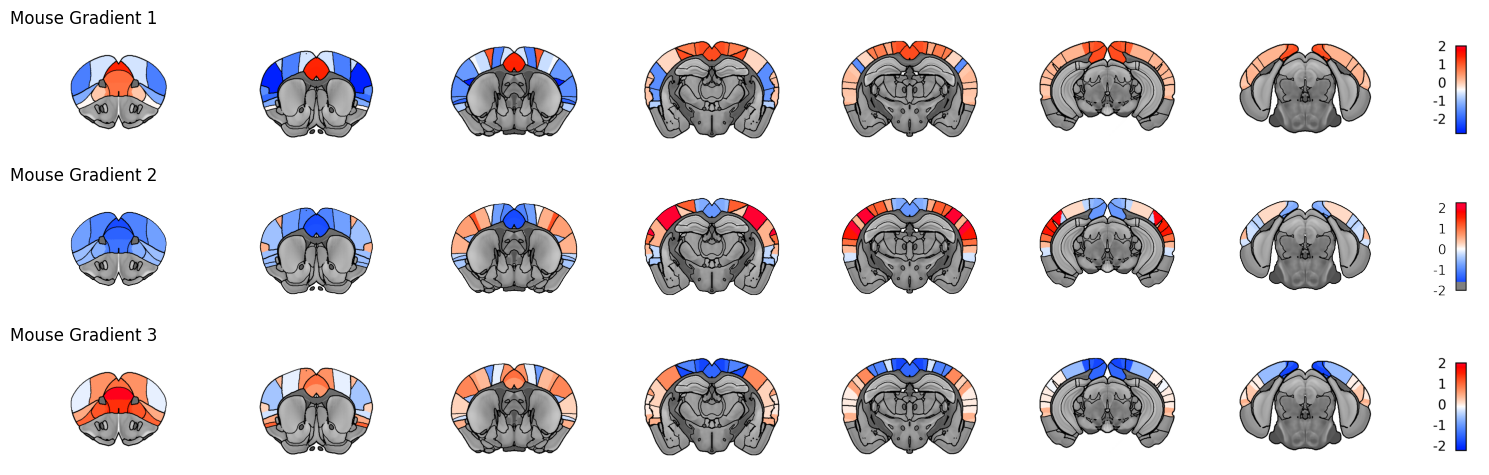

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(15, 5))

axs[0].imshow(g_1)
axs[0].axis('off') 
axs[0].set_title("Mouse Gradient 1",loc='left') 

axs[1].imshow(g_2)
axs[1].axis('off')
axs[1].set_title("Mouse Gradient 2",loc='left')

axs[2].imshow(g_3)
axs[2].axis('off')
axs[2].set_title("Mouse Gradient 3",loc='left')

plt.tight_layout() 
plt.show()

In [22]:
graph_vis_map_l = []

for graph_map in [graph_map_dict_gradient['Gradient_0'],graph_map_dict_gradient['Gradient_1'],graph_map_dict_gradient['Gradient_2']]:

    graph_map = stats.zscore(graph_map)
    
    graph_zero_data = np.zeros_like(Human_127_atlas_data)
    for i,ele in enumerate(graph_map):
        graph_zero_data[Human_127_atlas_data==i+1] = ele
    graph_vis_map = image.new_img_like(Human_127_atlas,graph_zero_data)
    graph_vis_map_l.append(graph_vis_map)

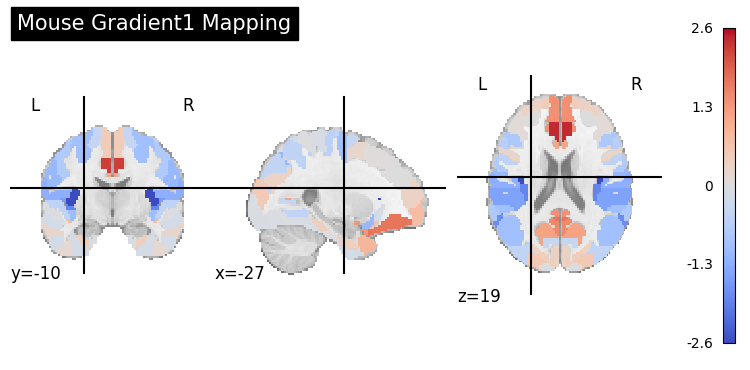

In [23]:
plotting.plot_stat_map(graph_vis_map_l[0],title='Mouse Gradient1 Mapping',cmap='coolwarm',cut_coords=(-27,-10,19))

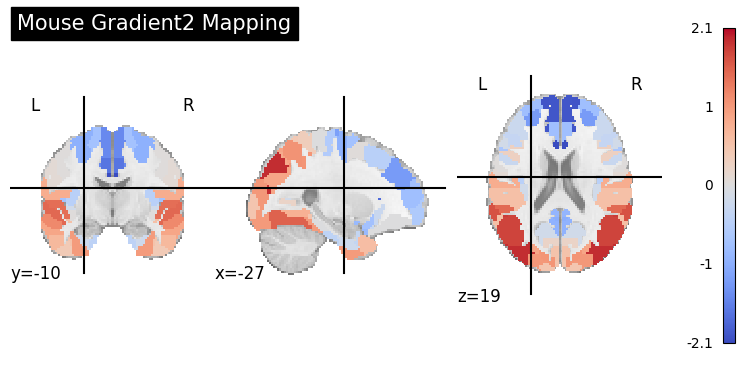

In [24]:
plotting.plot_stat_map(graph_vis_map_l[1],title='Mouse Gradient2 Mapping',cmap='coolwarm',cut_coords=(-27,-10,19))

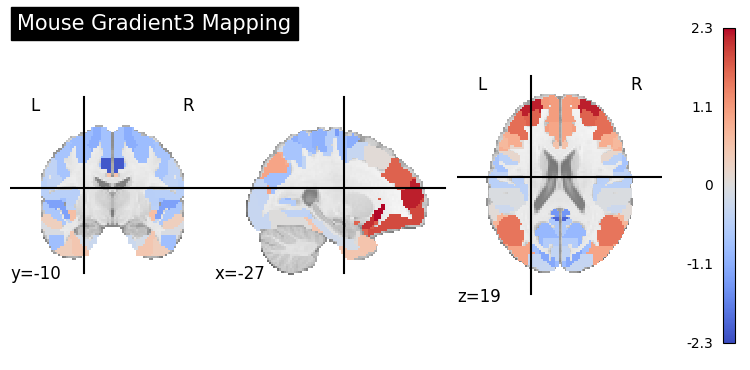

In [25]:
plotting.plot_stat_map(graph_vis_map_l[2],title='Mouse Gradient3 Mapping',cmap='coolwarm',cut_coords=(-27,-10,19))

### human gradient

In [26]:
with open('./gradient_file/human_gradient_dict_nozscore.pkl','rb') as f:
    Human_gradient_dict = pickle.load(f)

In [27]:
human_gradient_l = []

for gradient in [Human_gradient_dict['Gradient_0'],Human_gradient_dict['Gradient_1'],Human_gradient_dict['Gradient_2']]:

    gradient = stats.zscore(gradient.values)
    gradient_zero_data = np.zeros_like(Human_127_atlas_data)
    
    for i,ele in enumerate(gradient):
        gradient_zero_data[Human_127_atlas_data==i+1] = ele
    gradient_map = image.new_img_like(Human_127_atlas,gradient_zero_data)
    human_gradient_l.append(gradient_map)

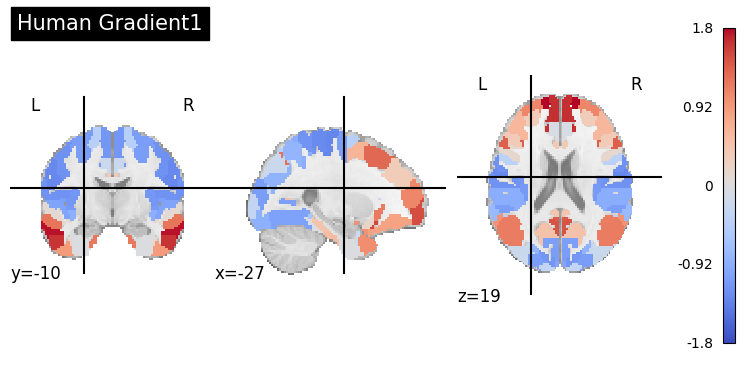

In [28]:
plotting.plot_stat_map(human_gradient_l[0],title='Human Gradient1',cmap='coolwarm',cut_coords=(-27,-10,19))

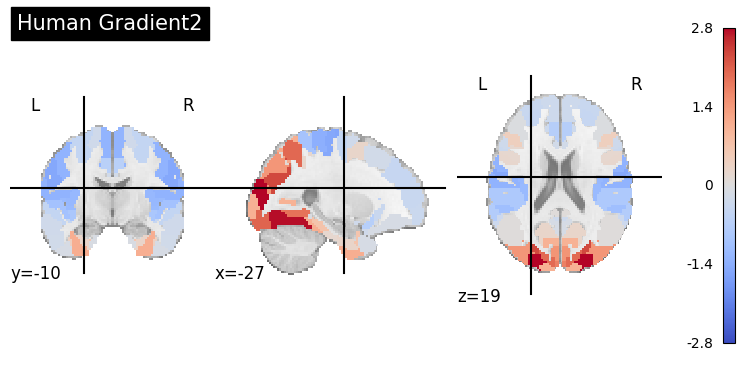

In [29]:
plotting.plot_stat_map(human_gradient_l[1],title='Human Gradient2',cmap='coolwarm',cut_coords=(-27,-10,19))

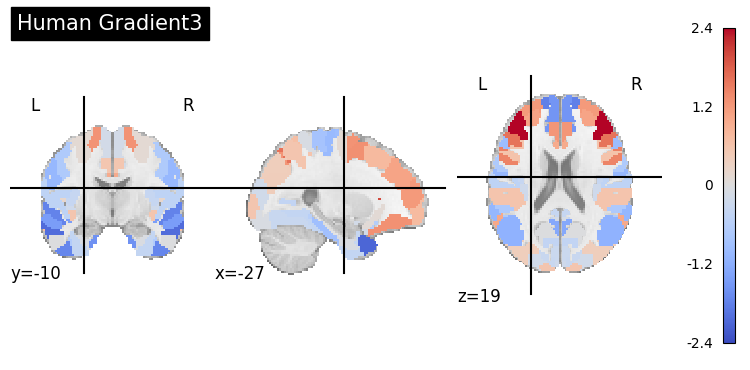

In [30]:
plotting.plot_stat_map(human_gradient_l[2],title='Human Gradient3',cmap='coolwarm',cut_coords=(-27,-10,19))

### correlation

In [31]:
Human_matrix_gradient = []
for key in Human_gradient_dict.keys():
    Human_matrix_gradient.append(Human_gradient_dict[key].iloc[:,0].values[:105])

In [32]:
Human_matrix_gradient = np.asarray(Human_matrix_gradient)

In [33]:
similarity_matrix_gradient = np.zeros((3,3))
for i,mouse_v in enumerate(Mouse_mapping_matrix_gradient):
    for j,human_v in enumerate(Human_matrix_gradient):
        r = stats.pearsonr(mouse_v,human_v)[0]
        similarity_matrix_gradient[i,j] = r

In [34]:
similarity_matrix_gradient

array([[ 0.37392101,  0.11099569, -0.15477924],
       [-0.2088412 ,  0.4626086 , -0.11420495],
       [ 0.52904265, -0.02936634,  0.1609119 ]])

<Axes: >

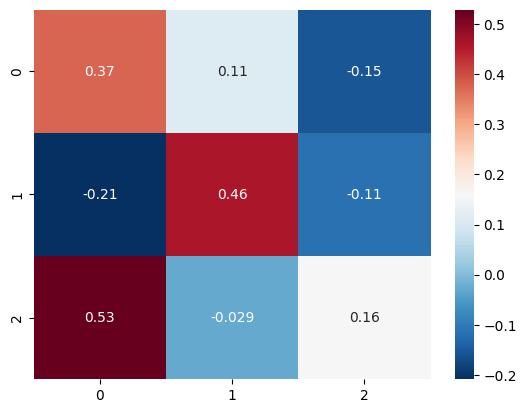

In [35]:
sns.heatmap(similarity_matrix_gradient,cmap='RdBu_r',annot=True)

## Optogenetic

### mouse opto map

In [36]:
ai_y= mpimg.imread("./optogenetic/mouse_opto_ai_y.png")
drn_y= mpimg.imread("./optogenetic/mouse_opto_drn_y.png")

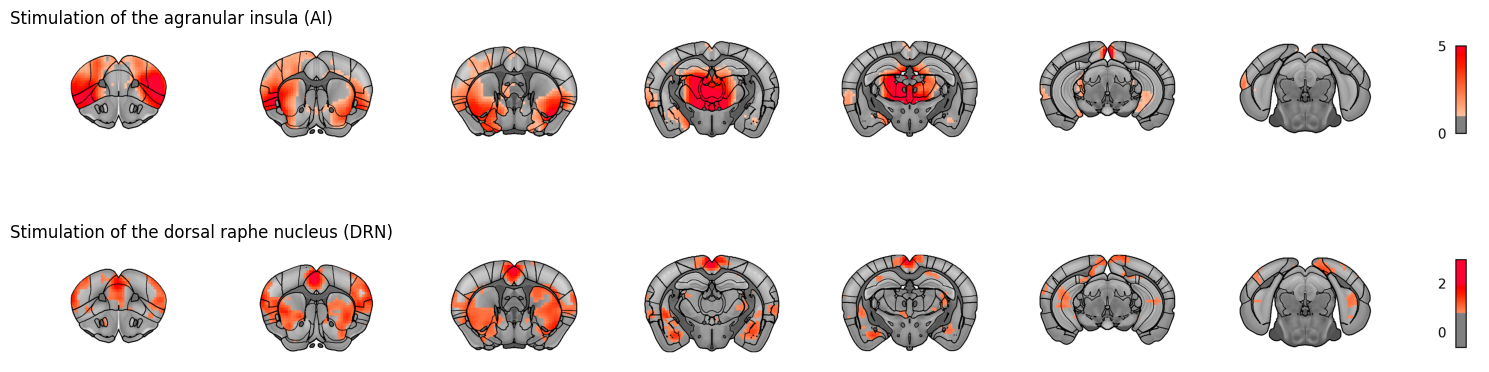

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(15, 5))

axs[0].imshow(ai_y)
axs[0].axis('off')
axs[0].set_title("Stimulation of the agranular insula (AI)",loc='left')

axs[1].imshow(drn_y)
axs[1].axis('off')
axs[1].set_title("Stimulation of the dorsal raphe nucleus (DRN)",loc='left')

plt.tight_layout() 
plt.show()

### translate mouse ai stimulated pattern to human

In [38]:
ai_graph_map_list = []
for i in range(500):
    Human_matrix = Human_Mouse_embedding[i][:127]
    Mouse_matrix = Human_Mouse_embedding[i][127:]
    Human_matrix = pd.DataFrame(Human_matrix)
    Mouse_matrix = pd.DataFrame(Mouse_matrix)
    ai_graph_map_list.append(dual_mapping_data('./optogenetic/z_mean_map_ai.pkl',Mouse_matrix,Human_matrix,dual_type='embedding',i=i))

In [39]:
ai_graph_map_mean = np.mean(np.asarray(ai_graph_map_list),axis=0)

In [40]:
ai_graph_map_mean_dataframe = pd.DataFrame(ai_graph_map_mean[0])

In [41]:
ai_graph_map_mean_dataframe.index = Human_select_region

In [42]:
ai_graph_map_mean_dataframe.sort_values(by=0,ascending=False).head(30)

,0
rTtha,0.732512
mPFtha,0.568260
PPtha,0.469093
dIg,0.429137
vId/vIg,0.416277
G,0.389577
vIa,0.330202
Otha,0.286257
posterovemtral putamen,0.283502
dId,0.257844


In [43]:
ai_graph_map_mean_dataframe = stats.zscore(ai_graph_map_mean_dataframe)

In [44]:
Human_127_info

,Anatomical Name,Full Name,Atlas Type,Left Index,Right Index,Atlas Index
0,A8m,"A8m, medial area 8",BN,1,2,1
1,A8dl,"A8dl, dorsolateral area 8",BN,3,4,2
2,A9l,"A9l, lateral area 9",BN,5,6,3
3,A6dl,"A6dl, dorsolateral area 6",BN,7,8,4
4,A6m,"A6m, medial area 6",BN,9,10,5
...,...,...,...,...,...,...
122,rTtha,"rTtha, rostral temporal thalamus",BN,237,238,123
123,PPtha,"PPtha, posterior parietal thalamus",BN,239,240,124
124,Otha,"Otha, occipital thalamus",BN,241,242,125
125,cTtha,"cTtha, caudal temporal thalamus",BN,243,244,126


In [45]:
ai_z_score_map = np.zeros_like(Human_127_atlas_data)

for i,row in Human_127_info.iterrows():
    
    anatomical = row['Anatomical Name']
    
    if anatomical not in Human_select_region:
        continue
  
    atlas_index = row['Atlas Index']
    z_score = ai_graph_map_mean_dataframe[ai_graph_map_mean_dataframe.index==anatomical].iloc[:,0].values[0]
    
    ai_z_score_map[Human_127_atlas_data==atlas_index] = z_score

In [46]:
ai_z_score_map[ai_z_score_map<0] = 0

In [47]:
Synthetic_insula_stimulated_img = image.new_img_like(Human_127_atlas,ai_z_score_map)

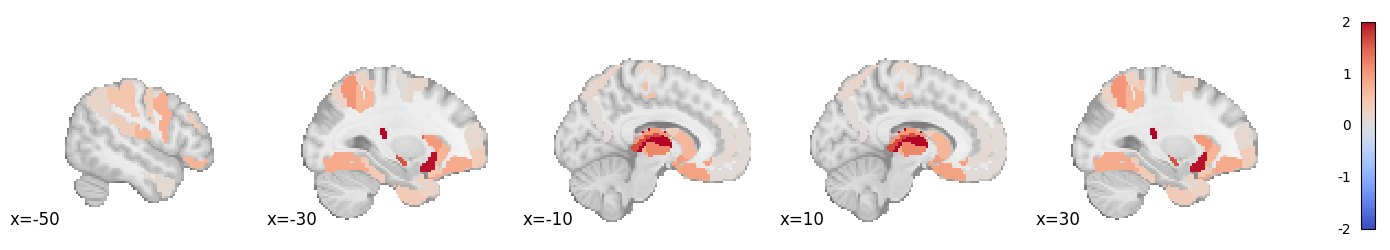

In [48]:
plotting.plot_stat_map(Synthetic_insula_stimulated_img ,draw_cross=False,display_mode='x',
                       annotate=True,cut_coords=range(-50,50,20),vmax=2,cmap='coolwarm',symmetric_cbar=True)

### translate mouse drn stimulated pattern to human

In [49]:
drn_graph_map_list = []
for i in range(500):
    Human_matrix = Human_Mouse_embedding[i][:127]
    Mouse_matrix = Human_Mouse_embedding[i][127:]
    Human_matrix = pd.DataFrame(Human_matrix)
    Mouse_matrix = pd.DataFrame(Mouse_matrix)
    drn_graph_map_list.append(dual_mapping_data('./optogenetic/z_mean_map_drn.pkl',Mouse_matrix,Human_matrix,dual_type='embedding',i=i))

In [50]:
drn_graph_map_mean = np.mean(np.asarray(drn_graph_map_list),axis=0)
drn_graph_map_mean_dataframe = pd.DataFrame(drn_graph_map_mean[0])
drn_graph_map_mean_dataframe.index = Human_select_region
drn_graph_map_mean_dataframe = stats.zscore(drn_graph_map_mean_dataframe)

In [51]:
drn_z_score_map = np.zeros_like(Human_127_atlas_data)

for i,row in Human_127_info.iterrows():
    
    anatomical = row['Anatomical Name']
    
    if anatomical not in Human_select_region:
        continue
  
    atlas_index = row['Atlas Index']
    z_score = drn_graph_map_mean_dataframe[drn_graph_map_mean_dataframe.index==anatomical].iloc[:,0].values[0]
    
    drn_z_score_map[Human_127_atlas_data==atlas_index] = z_score

In [52]:
drn_z_score_map[drn_z_score_map<0] = 0

In [53]:
Synthetic_drn_stimulated_img = image.new_img_like(Human_127_atlas,drn_z_score_map)

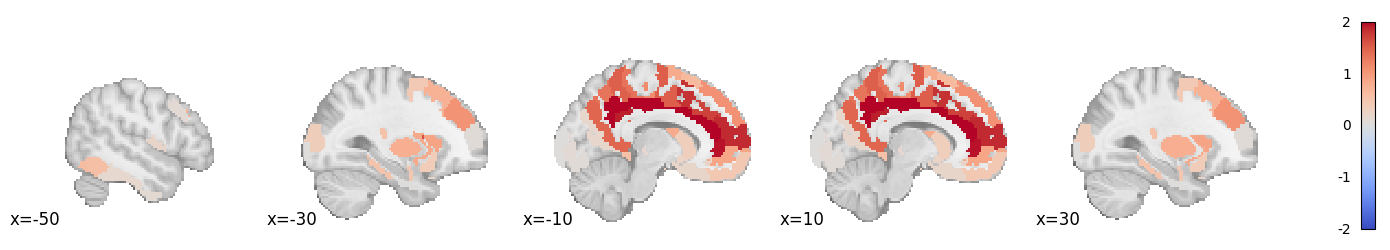

In [54]:
plotting.plot_stat_map(Synthetic_drn_stimulated_img ,draw_cross=False,display_mode='x',
                       annotate=True,cut_coords=range(-50,50,20),vmax=2,cmap='coolwarm',symmetric_cbar=True)

## Autism Structural Deviation

### load deviation pattern

In [55]:
human_deviation_pattern = pd.read_csv('./autism_structural_deviation/z_autism_regress.csv')

In [56]:
human_deviation_pattern.set_index('Unnamed: 0',inplace=True,drop=True)

In [57]:
with open('./autism_structural_deviation/mouse_mutation.pkl','rb') as f:
    mouse_mutation_pattern = pickle.load(f)

In [58]:
select_gene = ['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']

### translate mouse mutation pattern to human

In [59]:
mutation_graph_map_list = []

for i in range(500):
    
    Human_matrix=Human_Mouse_embedding[i][:127]
    Mouse_matrix=Human_Mouse_embedding[i][127:]
    Human_matrix=pd.DataFrame(Human_matrix)
    Mouse_matrix=pd.DataFrame(Mouse_matrix)

    mutation_graph_map_list.append(dual_mapping_data('./autism_structural_deviation/mouse_mutation.pkl',Mouse_matrix,Human_matrix,dual_type='embedding',i=i)) 
    mutation_graph_map = np.mean(np.asarray(mutation_graph_map_list),axis=0)   

In [60]:
mutation_graph_map = stats.zscore(mutation_graph_map,axis=1)
mutation_graph_map = pd.DataFrame(mutation_graph_map,index=select_gene,columns=Human_select_region)

### individual gene risk scores based on mouse model

In [61]:
cross_species_autism_dataframe = pd.DataFrame()

for i in range(human_deviation_pattern.shape[0]):
    
    row_data = human_deviation_pattern.iloc[i].values
    corr_l = []
    
    for j in range(5):

        m_data = mutation_graph_map.iloc[j].values
        corr_ = stats.pearsonr(row_data,m_data)[0]
        corr_l.append(corr_)

    cross_species_autism_dataframe[i] = corr_l

cross_species_autism_dataframe = cross_species_autism_dataframe.T
cross_species_autism_dataframe.index = human_deviation_pattern.index
cross_species_autism_dataframe.columns = select_gene

### load AHBA gene expression

In [62]:
AHBA_ex = pd.read_csv('./autism_structural_deviation/AHBA_expression.csv')

In [63]:
AHBA_ex.set_index('gene_symbol',inplace=True,drop=True)

### individual gene risk scores based on AHBA

In [64]:
AHBA_autism_dataframe = pd.DataFrame()

for i in range(human_deviation_pattern.shape[0]):
    
    row_data = human_deviation_pattern.iloc[i].values
    corr_l = []
    
    for j in range(5):

        m_data = AHBA_ex.iloc[j].values
        corr_ = stats.pearsonr(row_data,m_data)[0]
        corr_l.append(corr_)

    AHBA_autism_dataframe[i] = corr_l

AHBA_autism_dataframe = AHBA_autism_dataframe.T
AHBA_autism_dataframe.index = human_deviation_pattern.index
AHBA_autism_dataframe.columns = select_gene

### correlate risk scores

In [65]:
stats.pearsonr(AHBA_autism_dataframe.values.flatten(),cross_species_autism_dataframe.values.flatten())

PearsonRResult(statistic=0.19780599996495277, pvalue=9.645342333393955e-12)

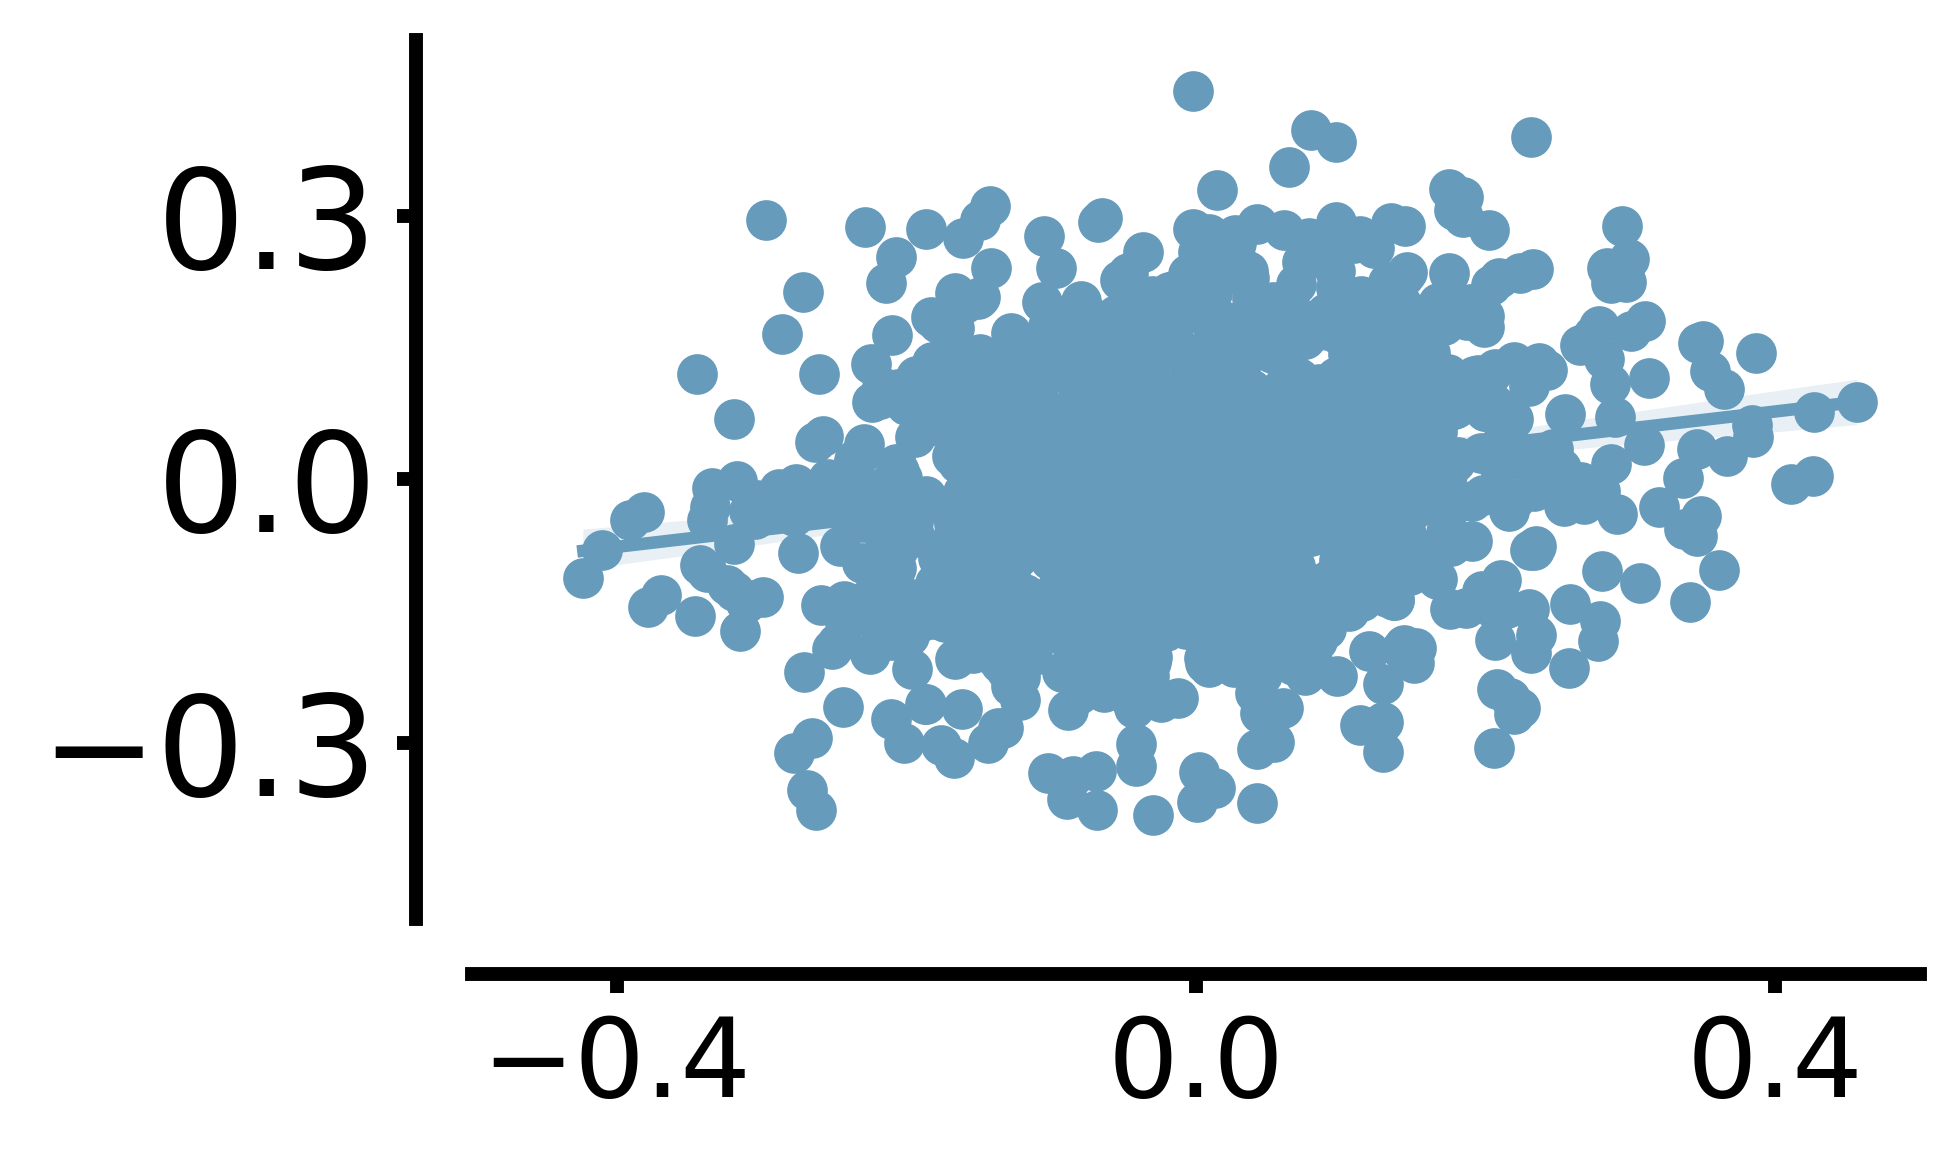

In [66]:
fig,ax=plt.subplots(1,1,figsize=(5,3),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.set_ylim(-0.5,0.5)
ax.set_yticks([-0.3,0.0,0.3])

ax.set_xlim(-0.5, 0.5)
ax.set_xticks([-0.4,0.0,0.4])

ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=AHBA_autism_dataframe.values.flatten(),y=cross_species_autism_dataframe.values.flatten(),color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()

### correlate risk scores in specific gene

In [67]:
dict_gene_ = {}
for gene in ['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']:
    
    AHBA_scores = AHBA_autism_dataframe[gene].values
    mouse_mutation_scores = cross_species_autism_dataframe[gene].values
    r,p = stats.pearsonr(AHBA_scores,mouse_mutation_scores)
    
    dict_gene_[gene] = (r,p)

In [68]:
dict_gene_

{'Dvl1': (0.31097966299832985, 1.2856342421457855e-06),
 'Magel2': (0.4539929971213874, 3.006415159337541e-13),
 'Slc6a4': (0.015197117448080994, 0.8175170464932578),
 'Sgsh': (0.0022482421778189507, 0.972770770531957),
 'Shank3--': (0.20016237908524406, 0.0021402800433746364)}

### correlate sythetic mutation pattern with AHBA gene expression

In [69]:
dict_gene_ = {}
for gene1,gene2 in zip(['DVL1','MAGEL2','SLC6A4','SGSH','SHANK3'],['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']):
    r,p = stats.pearsonr(AHBA_ex.T[gene1].values,mutation_graph_map.T[gene2].values)
    dict_gene_[gene1] = (r,p)

In [70]:
dict_gene_

{'DVL1': (0.09730098359735105, 0.2764762751949797),
 'MAGEL2': (0.35261868093120274, 4.7844908589445697e-05),
 'SLC6A4': (-0.06206296971309106, 0.4882044955368923),
 'SGSH': (0.04501704457506573, 0.6152770360499242),
 'SHANK3': (-0.0675934876558286, 0.4502055153591841)}

In [71]:
dict_gene_ = {}
for gene1,gene2 in zip(['DVL1','MAGEL2','SLC6A4','SGSH','SHANK3'],['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']):
    r,p = stats.pearsonr(AHBA_ex.T[gene1].values[:105],mutation_graph_map.T[gene2].values[:105])
    dict_gene_[gene1] = (r,p)

In [72]:
dict_gene_

{'DVL1': (0.0916300480034764, 0.35255399643853086),
 'MAGEL2': (0.5926688876223712, 2.7295029485344006e-11),
 'SLC6A4': (-0.008573793435634131, 0.9308263894863193),
 'SGSH': (0.14000334182711952, 0.154313223725472),
 'SHANK3': (0.09513931972764547, 0.3343394422909406)}

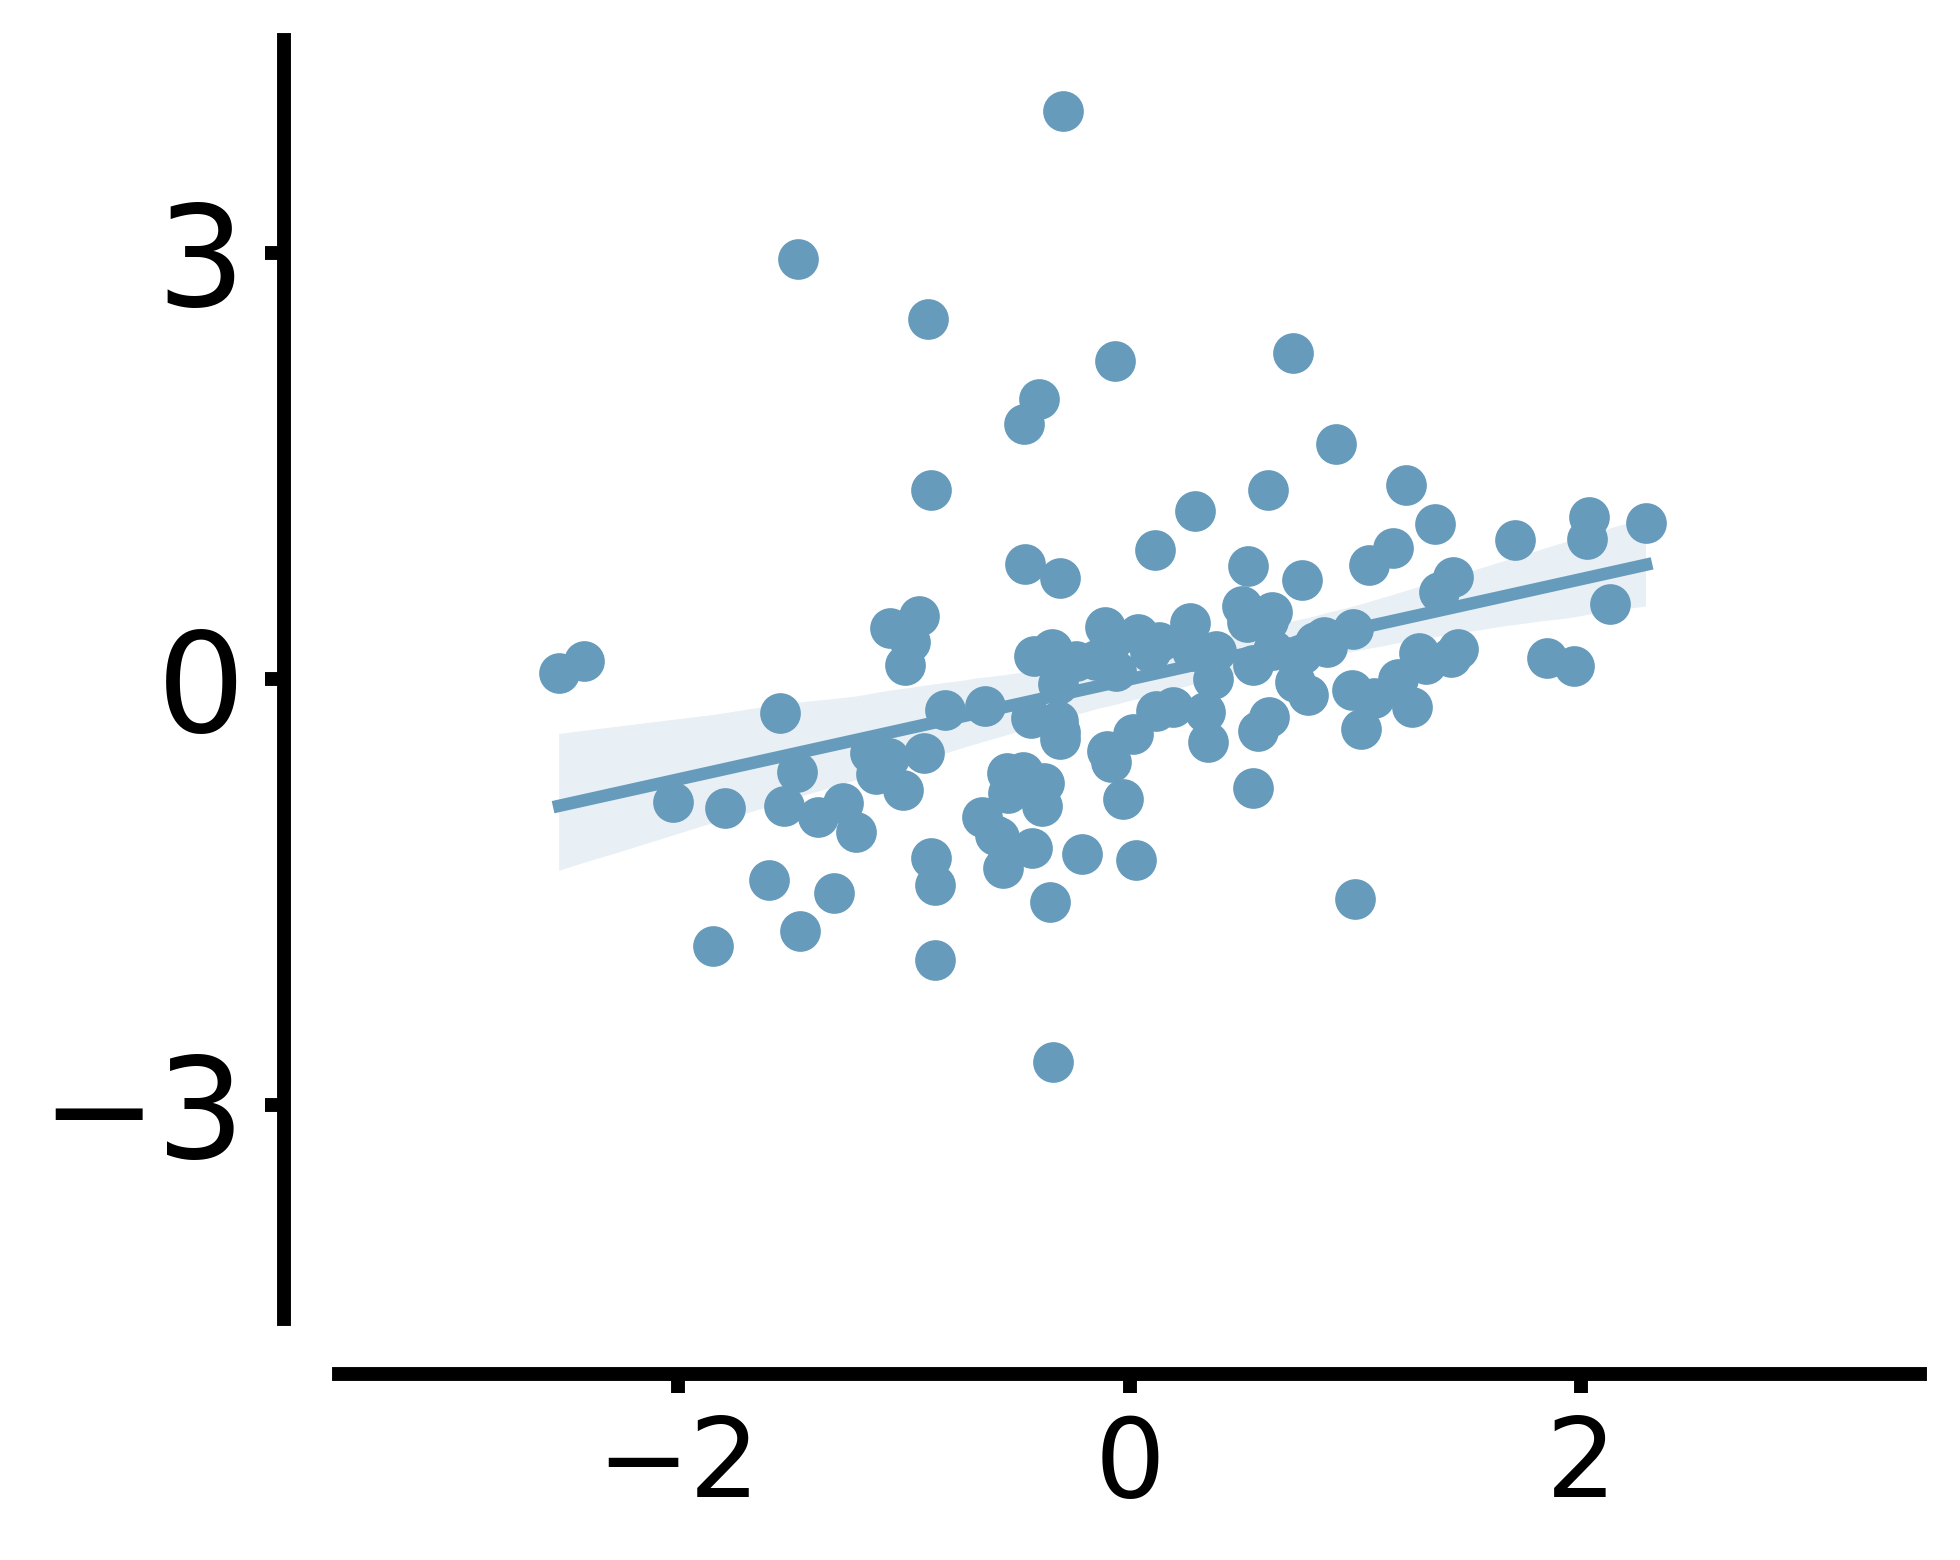

In [73]:
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.set_ylim(-4.5,4.5)
ax.set_yticks([-3,0,3])

ax.set_xlim(-3.5, 3.5)
ax.set_xticks([-2,0,2])

ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=stats.zscore(mutation_graph_map.T['Magel2'].values.flatten()),y=stats.zscore(AHBA_ex.T['MAGEL2'].values.flatten()),color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()

### Visulization

In [74]:
mouse_magel2_mutation = mpimg.imread('./autism_structural_deviation/Mouse_magel2.png')
human_magel2_synthetic = mpimg.imread('./autism_structural_deviation/Human_Magle2_Synthetic_Map.png')
human_magel2_synthetic_zsoce = mpimg.imread('./autism_structural_deviation/Human_Magel2_Synthetic_Map_zscore.png')
AHBA_magel2_zscore = mpimg.imread('./autism_structural_deviation/Human_Magel2_Allen_expression.png')

Text(0.0, 1.0, 'Mouse magel2 mutation pattern')

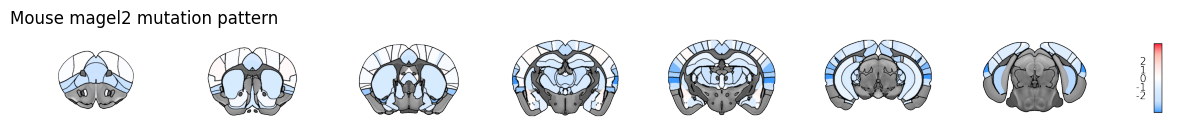

In [75]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

axs.imshow(mouse_magel2_mutation)
axs.axis('off') 
axs.set_title("Mouse magel2 mutation pattern",loc='left') 

Text(0.0, 1.0, 'Human magel2 synthetic')

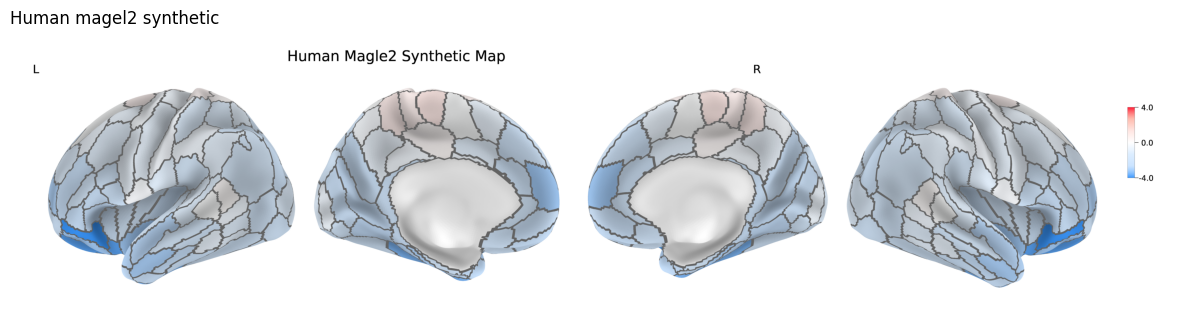

In [76]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.imshow(human_magel2_synthetic)
axs.axis('off')
axs.set_title("Human magel2 synthetic",loc='left') 

Text(0.0, 1.0, 'Human magel2 synthetic zscore')

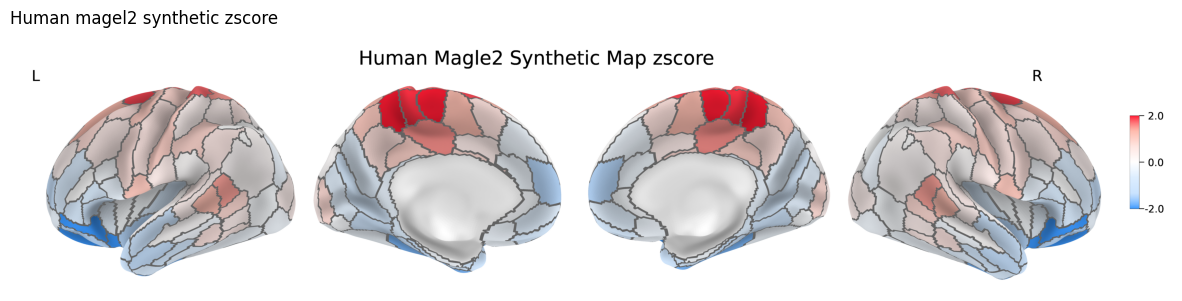

In [77]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.imshow(human_magel2_synthetic_zsoce)
axs.axis('off')
axs.set_title('Human magel2 synthetic zscore',loc='left')

Text(0.0, 1.0, 'AHBA magel2 zscore')

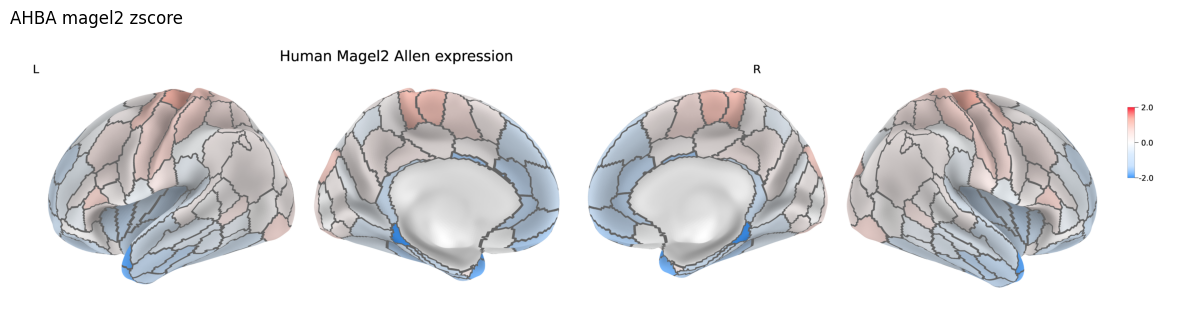

In [78]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.imshow(AHBA_magel2_zscore)
axs.axis('off')
axs.set_title('AHBA magel2 zscore',loc='left')

### load behavior data

In [79]:
autism_meta = pd.read_csv('./autism_structural_deviation/meta_info_ABIDE.csv')
autism_meta['SUB_ID'] = ['sub-00{}'.format(i) for i in autism_meta['SUB_ID'].values]
autism_meta.set_index('SUB_ID',inplace=True,drop=True)
autism_info = human_deviation_pattern.index.values
autism_meta = autism_meta.T[autism_info].T

In [80]:
behavior_l = ['FIQ','VIQ','PIQ','ADOS_COMM','ADOS_SOCIAL','ADOS_STEREO_BEHAV']

In [81]:
autism_meta = autism_meta[behavior_l]

In [82]:
autism_meta

,FIQ,VIQ,PIQ,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV
SUB_ID,,,,,,
sub-0050952,134.0,139.0,120.0,7.0,10.0,4.0
sub-0050953,132.0,139.0,117.0,3.0,10.0,3.0
sub-0050954,78.0,79.0,80.0,3.0,8.0,4.0
sub-0050955,93.0,96.0,91.0,3.0,11.0,3.0
sub-0050956,115.0,115.0,110.0,2.0,8.0,5.0
...,...,...,...,...,...,...
sub-0050528,100.0,90.0,109.0,5.0,7.0,1.0
sub-0050529,128.0,122.0,127.0,4.0,9.0,1.0
sub-0050530,106.0,120.0,91.0,3.0,10.0,0.0


In [83]:
magel2_scores_based_on_mouse = cross_species_autism_dataframe['Magel2'].values

In [84]:
gene_behavior_l = []
gene_clinic_dataframe = pd.DataFrame()

for name_ in autism_meta.columns.values:
    
    behavior_pattern = autism_meta[name_].values
    
    behavior_pattern = np.array([float(x) if str(x).replace('.', '', 1).isdigit() else np.nan for x in behavior_pattern])
    mask = ~np.isnan(behavior_pattern) & (behavior_pattern!=-9999.0)
    
    arr1_filtered = magel2_scores_based_on_mouse[mask]
    arr2_filtered = behavior_pattern[mask]
    
    corr = stats.pearsonr(arr1_filtered,arr2_filtered)
    
    gene_behavior_l.append(corr)
    
gene_clinic_dataframe['magel2'] = gene_behavior_l

In [85]:
gene_clinic_dataframe

,magel2
0,"(-0.17657536932333698, 0.007013404055078141)"
1,"(-0.07795466860082739, 0.23588641460034124)"
2,"(-0.18717492106148584, 0.004224509163949944)"
3,"(-0.08570567055260456, 0.25533156937955576)"
4,"(0.0025750174236130415, 0.9727870157318773)"
5,"(-0.018771597619276076, 0.8046910213503498)"


In [86]:
behavior_pattern = autism_meta['FIQ'].values
behavior_pattern = np.array([float(x) if str(x).replace('.', '', 1).isdigit() else np.nan for x in behavior_pattern])
mask = ~np.isnan(behavior_pattern) & (behavior_pattern!=-9999.0)

In [87]:
arr1_filtered = magel2_scores_based_on_mouse[mask]
arr2_filtered = behavior_pattern[mask]

In [88]:
stats.pearsonr(arr1_filtered,arr2_filtered)

PearsonRResult(statistic=-0.17657536932333698, pvalue=0.007013404055078141)

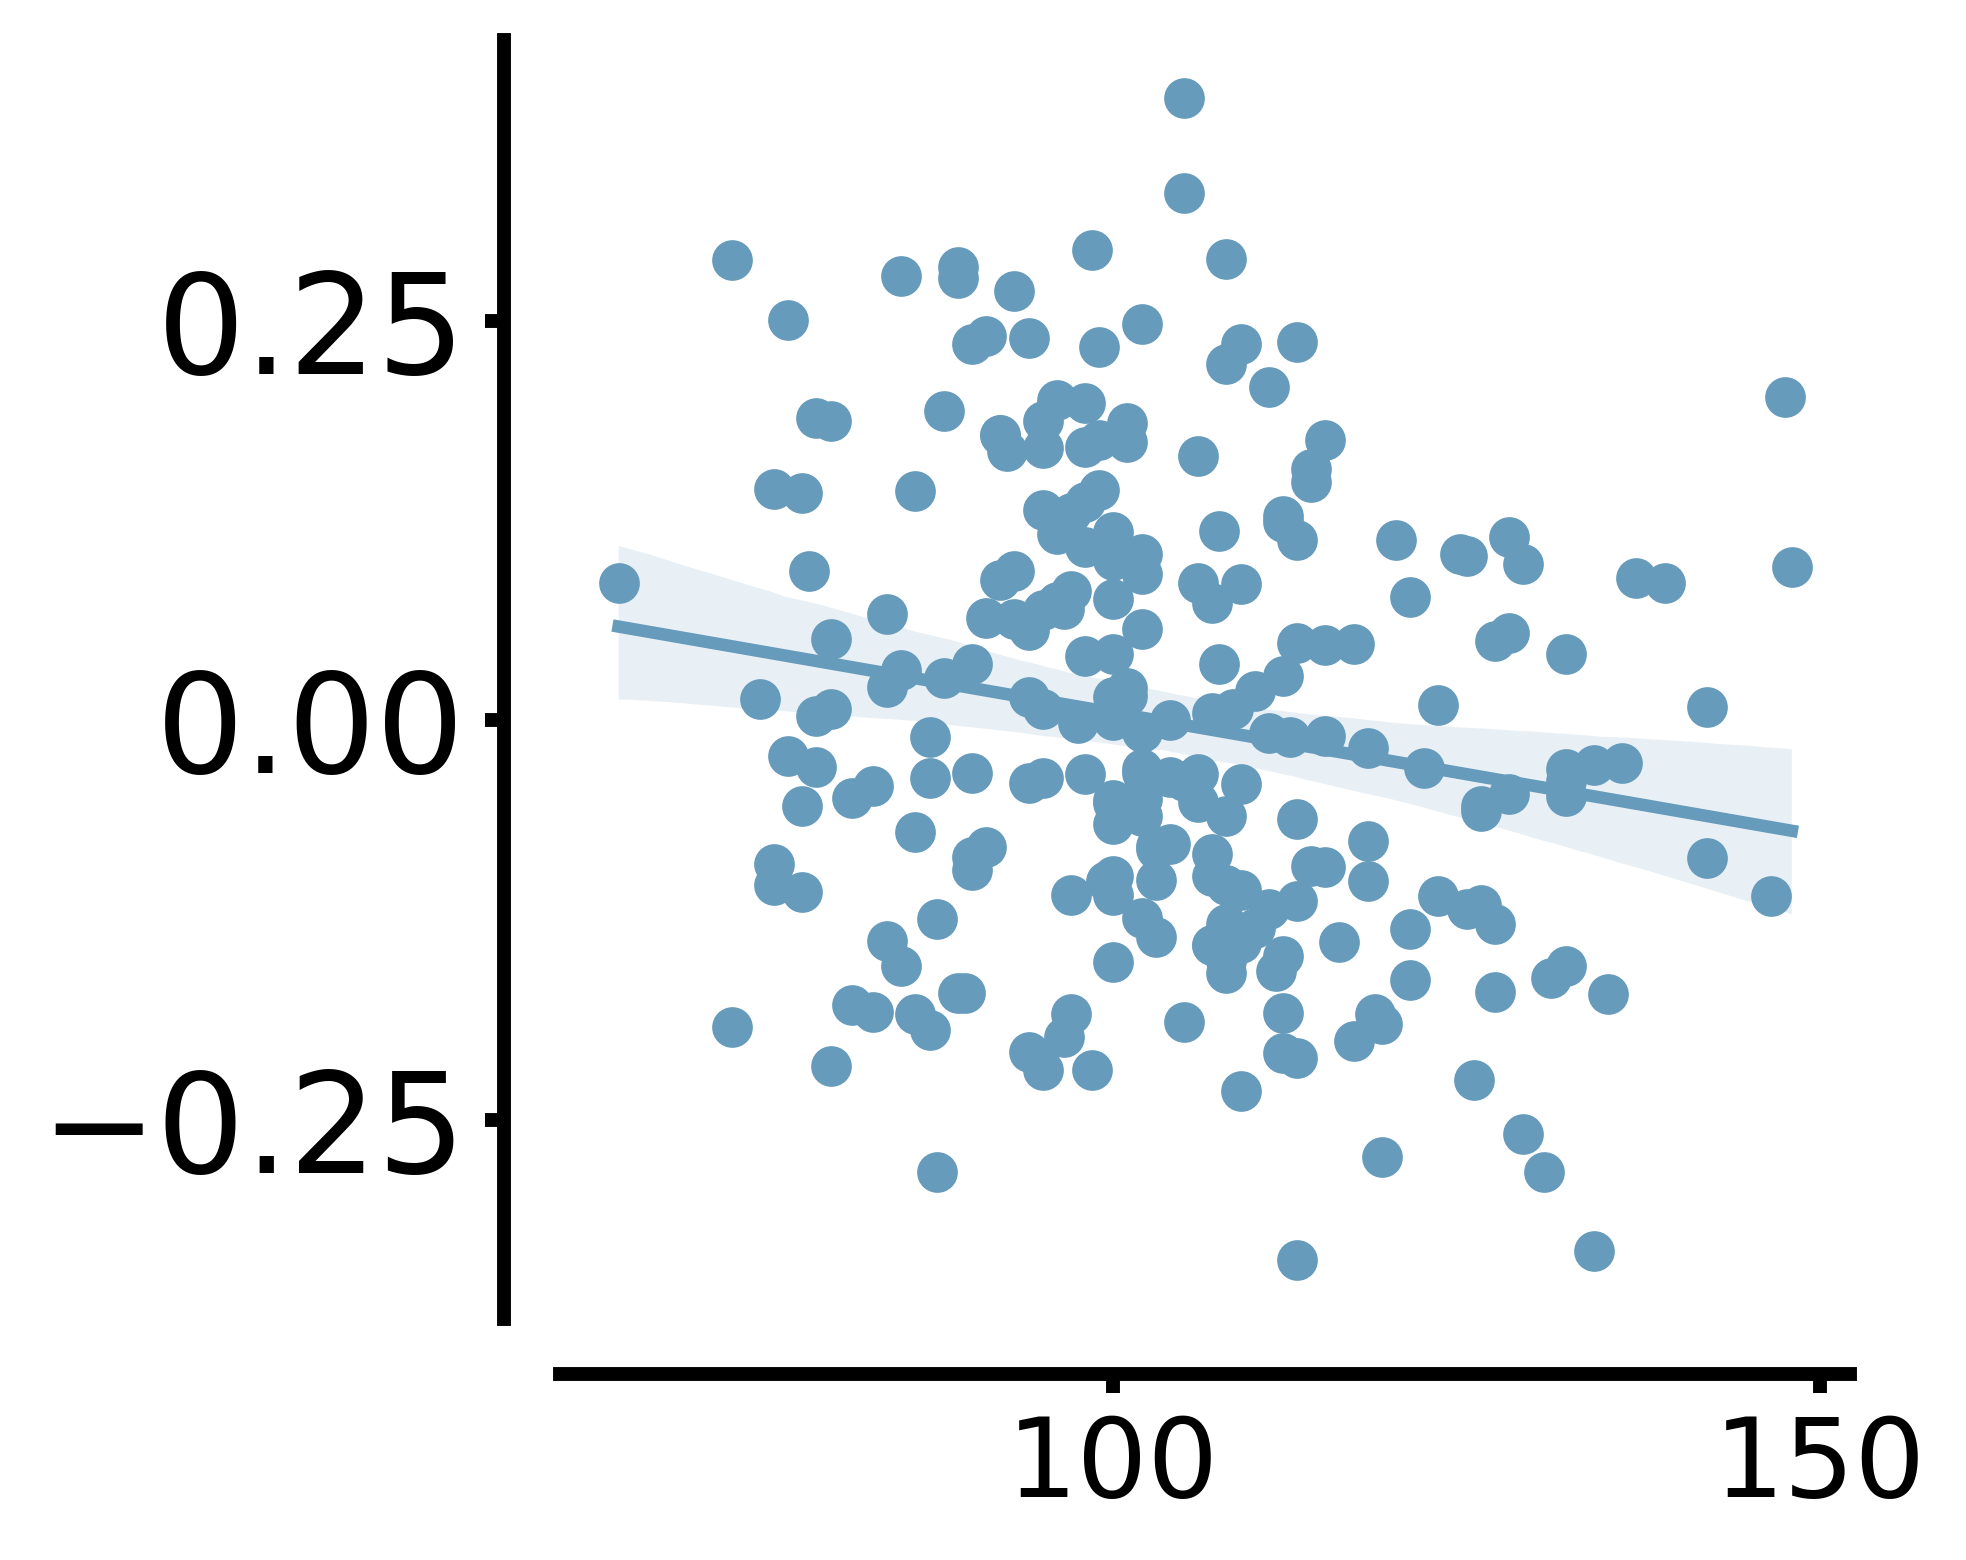

In [89]:
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=arr2_filtered,y=arr1_filtered,color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()